In [1]:
import numpy as np 
import pandas as pd 
import os
import PIL
from PIL import Image, ImageDraw as D
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline 


##  1. Data Preparation 

### Loading data 

In [2]:
path = '/kaggle/input/cryptopunks/imgs/imgs/'

## list all images
images = os.listdir(path)


<Figure size 576x576 with 0 Axes>

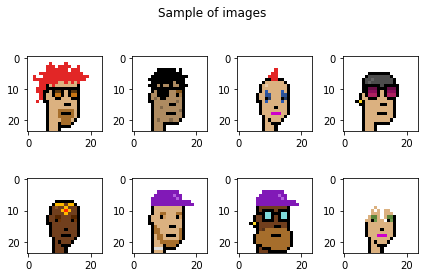

In [3]:
def plotImages(images):
    ## plot a sample of the photos 
    plt.figure(figsize=(8,8))
    fig, ax =plt.subplots(2,4)
    fig.suptitle("Sample of images")
    indx=0


    for i in range(2):
        for j in range(4):
            
            if type(images[indx])== str:
                ax[i,j].imshow(Image.open(path+images[indx]))
            else:
                ax[i,j].imshow(images[indx])
                
            indx = indx+1
    plt.tight_layout()
    plt.show()
            
plotImages(images)

In [4]:
images = [np.array(Image.open(path+img).resize((64,64)))[:,:,:3] for img in images]

for i in range(len(images)):
    images[i] = ((images[i] - images[i].min())/(255 - images[i].min()))

images = np.array(images) 

In [5]:
images[0].shape

(64, 64, 3)

We need to only focus on the generation of the face's features. To do so, we'll have to crop the images to only let the face appear and remove the background.

<Figure size 576x576 with 0 Axes>

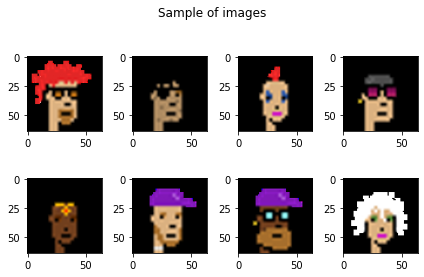

In [6]:
plotImages(images)

## 2. Modeling 

In [7]:
X = tf.cast(images,tf.float32)

2022-12-08 18:36:18.453779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 18:36:18.551582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 18:36:18.552416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 18:36:18.557254: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(X).batch(32)

In [9]:
train_dataset

<BatchDataset shapes: (None, 64, 64, 3), types: tf.float32>

In [10]:
latent_dim = 100

In [11]:
generator = keras.Sequential(
    [
    layers.Dense(4*4*512,input_shape=[latent_dim]),
    layers.Reshape([4,4,512]),
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(128, kernel_size=2, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same")
    ],
    name="generator",
    
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              827392    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         2097408   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0 

In [12]:
discriminator = keras.Sequential(
    [
       
        layers.Conv2D(32, kernel_size=4, strides=2, padding="same",input_shape=[64,64, 3]),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1,activation='sigmoid')
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        1568      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)       

In [13]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [14]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))
            plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
            
            #plt.subplot(2, 3, k+1)
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
            #plt.show()
            ##plt.imshow(img)
            
        plt.tight_layout()
        plt.show()

## 3 Training  

Epoch 1/30


2022-12-08 18:36:25.325809: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-08 18:36:27.414232: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


313/313 [==============================] - 14s 17ms/step - d_loss: 0.2037 - g_loss: 3.6438


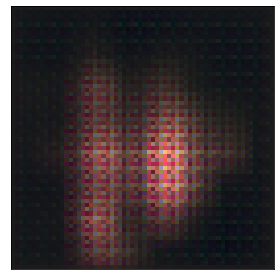

Epoch 2/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.2985 - g_loss: 3.1876


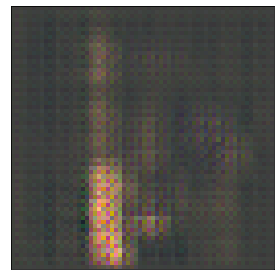

Epoch 3/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.2490 - g_loss: 3.1143


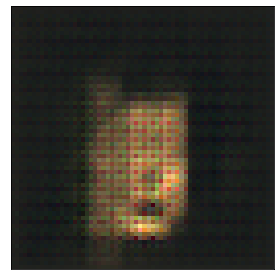

Epoch 4/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.3098 - g_loss: 3.0451


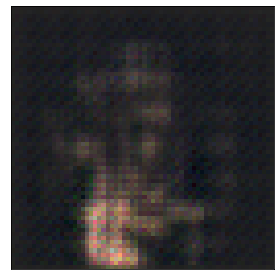

Epoch 5/30
313/313 [==============================] - 6s 18ms/step - d_loss: 0.2857 - g_loss: 3.0253


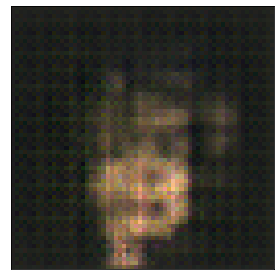

Epoch 6/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.2852 - g_loss: 2.5205


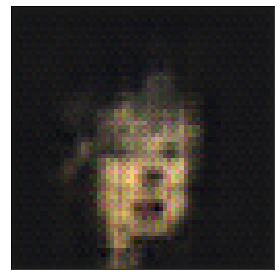

Epoch 7/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.2656 - g_loss: 3.3174


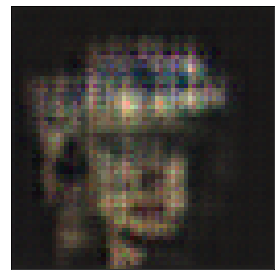

Epoch 8/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.2584 - g_loss: 3.0359


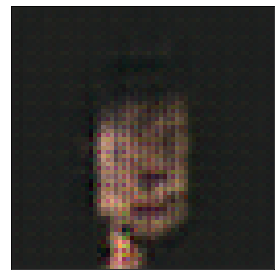

Epoch 9/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.2011 - g_loss: 3.2178


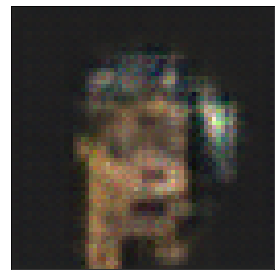

Epoch 10/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.2060 - g_loss: 3.0909


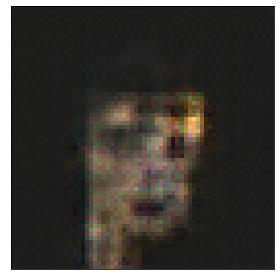

Epoch 11/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.1993 - g_loss: 3.1480


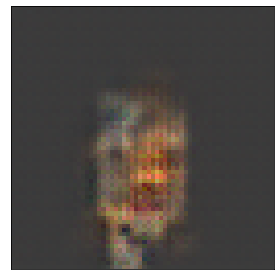

Epoch 12/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.2014 - g_loss: 3.2810


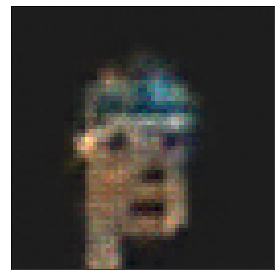

Epoch 13/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.2125 - g_loss: 3.2689


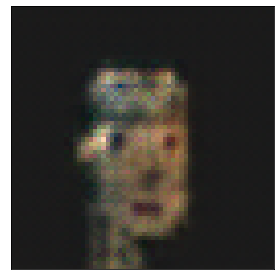

Epoch 14/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.2071 - g_loss: 3.2495


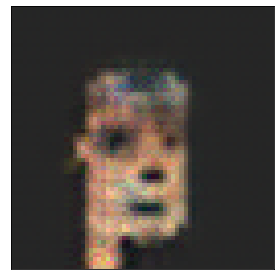

Epoch 15/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.2209 - g_loss: 3.4096


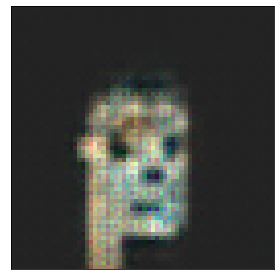

Epoch 16/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.2198 - g_loss: 3.3600


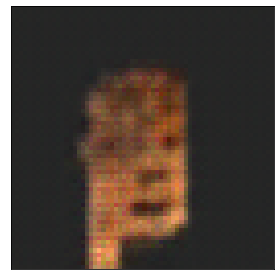

Epoch 17/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.2056 - g_loss: 3.6587


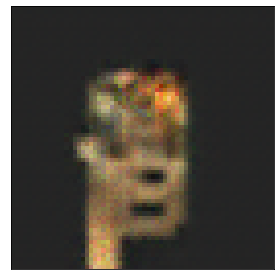

Epoch 18/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.2453 - g_loss: 3.4444


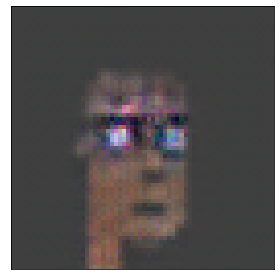

Epoch 19/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.1894 - g_loss: 3.4160


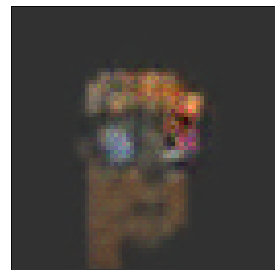

Epoch 20/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.2136 - g_loss: 3.5253


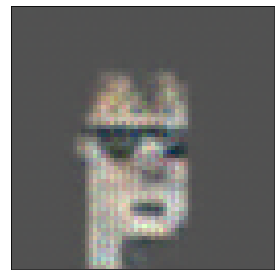

Epoch 21/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.1975 - g_loss: 3.6437


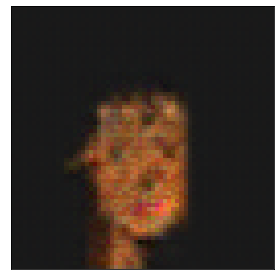

Epoch 22/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.1964 - g_loss: 3.7147


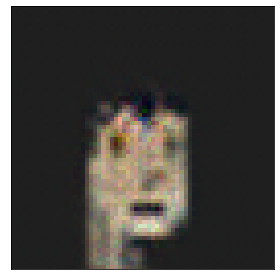

Epoch 23/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.1986 - g_loss: 3.7252


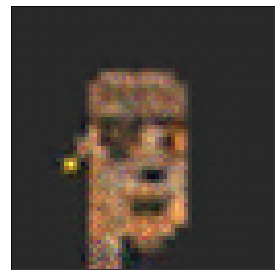

Epoch 24/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.1885 - g_loss: 3.6571


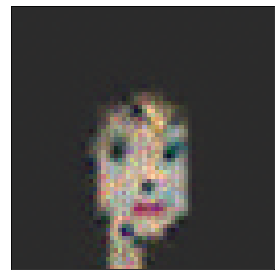

Epoch 25/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.1846 - g_loss: 3.6206


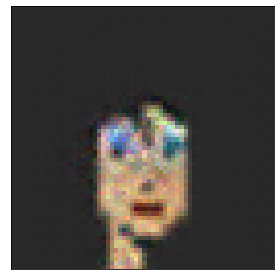

Epoch 26/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.1709 - g_loss: 3.7290


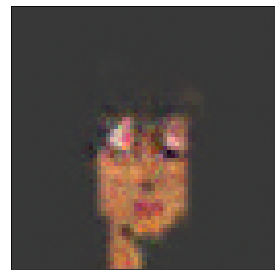

Epoch 27/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.1689 - g_loss: 3.9202


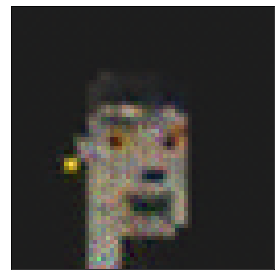

Epoch 28/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.1575 - g_loss: 4.0284


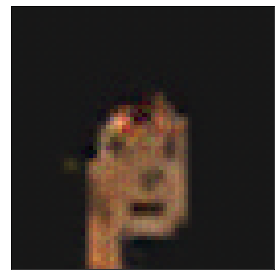

Epoch 29/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.1581 - g_loss: 3.9676


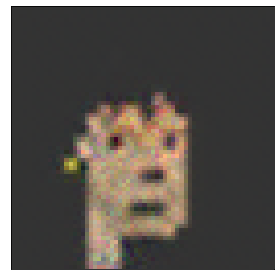

Epoch 30/30
313/313 [==============================] - 5s 17ms/step - d_loss: 0.1428 - g_loss: 4.0126


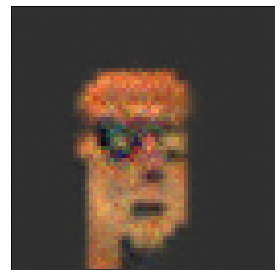

In [15]:
epochs = 30  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    train_dataset, epochs=epochs, callbacks=[GANMonitor(num_img=4, latent_dim=latent_dim)]
)

## **Thanks to the following notebooks** 
https://www.kaggle.com/code/sayakdasgupta/fake-faces-with-dcgans?kernelSessionId=33377438
https://github.com/AarohiSingla/DCGAN-Generating-Fake-Faces-with-DCGAN